# 2. Model Train

## Model Ensemble

In [3]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             classification_report, confusion_matrix)

In [4]:
def get_ensemble(models, input_shape, weights=None):
    x = tf.keras.layers.Input(shape=input_shape)
    if weights is None:
        weights = [np.ones((1, 5)) / len(models) for _ in range(len(models))]

    y = [model(x) * w for model, w in zip(models, weights)]
    y = tf.reduce_sum(y, axis=0)
    model = tf.keras.Model(inputs=x, outputs=y)
    return model


def get_data():

    noaug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        dtype=np.float32
    )

    train_generator = noaug_datagen.flow_from_directory(
        r"C:\8th sem\project\knee_OA_dl_app\src\dataset\train/",
        class_mode="categorical",
        target_size=(224, 224),
        shuffle=False,
    )

    valid_generator = noaug_datagen.flow_from_directory(
        r"C:\8th sem\project\knee_OA_dl_app\src\dataset\val/",
        class_mode="categorical",
        target_size=(224, 224),
        shuffle=False,
    )

    test_generator = noaug_datagen.flow_from_directory(
        r"C:\8th sem\project\knee_OA_dl_app\src\dataset\test/",
        class_mode="categorical",
        target_size=(224, 224),
        shuffle=False,
    )

    return train_generator, valid_generator, test_generator


def get_metrics(model, data, name=None, show_results=True):
    if name is None:
        name = model.name

    y_true = data.labels
    y_pred = np.argmax(model.predict(data), axis=1)

    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    accuracies = np.diag(cm)

    for i, a in enumerate(accuracies):
        report[str(i)]["accuracy"] = a

    if show_results:
        np.set_printoptions(precision=2)
        print(f"Accuracy Score - {name}: {acc}")
        print(f"Balanced Accuracy Score - {name}: {bal_acc}")
        print("\n")
        print(classification_report(y_true, y_pred))
        print("Confusion matrix:")
        print(cm)
        print("Classes accuracies", accuracies)
        np.set_printoptions(precision=None)

    return report


def compute_confusion_matrix(
    model,
    class_names,
    data,
    name=None,
):
    y_true = data.labels
    y_pred = np.argmax(model.predict(data), axis=1)

    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.subplots(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt=".2f",
        cmap="Purples",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix - {name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show(block=False)


def embed_preproc(model, preproc, input_shape):
    return tf.keras.models.Sequential(
        [
            tf.keras.layers.Lambda(preproc, input_shape=input_shape),
            tf.keras.models.load_model(model),
        ]
    )


def load_models(models, input_shape):
    return [
        embed_preproc(model, preproc, input_shape) for model, preproc in models
    ]

In [5]:
class_names = ["Healthy", "Doubtful", "Minimal", "Moderate", "Severe"]
model_name = "Ensemble"

# get generators
train, valid, test = get_data()
input_shape = 224, 224, 3

# load models
models = [
    [
        r"C:\8th sem\project\knee_OA_dl_app\src\models\model_Xception_ft.hdf5",
        tf.keras.applications.xception.preprocess_input,
    ]
]

models = load_models(models, input_shape)

Found 5778 images belonging to 5 classes.
Found 826 images belonging to 5 classes.
Found 1656 images belonging to 5 classes.


In [6]:
# model weights
def get_ensemble_weights(models, metric):
    metrics = []
    for model in models:
        report = get_metrics(model, data=train, show_results=False)
        metrics.append([report[str(i)][metric] for i in range(5)])

    metrics = np.array(metrics)
    model_weights = metrics / np.sum(metrics, axis=0)
    return model_weights

In [7]:
# ensemble of models
ensemble_mean = get_ensemble(
    models,
    input_shape=(224, 224, 3),
)

ensemble_acc = get_ensemble(
    models,
    input_shape=(224, 224, 3),
    weights=get_ensemble_weights(models, "accuracy"),
)

ensemble_f1 = get_ensemble(
    models,
    input_shape=(224, 224, 3),
    weights=get_ensemble_weights(models, "f1-score"),
)

181/181 [==============================] - 415s 2s/step


In [8]:
ensemble_mean.save("models/ensemble_mean.h5")
ensemble_acc.save("models/eemblensemble_acc.h5")
ensemble_f1.save("models/ens_f1.h5")

### Valid: ensemble_mean

26/26 [==============================] - 59s 2s/step
Accuracy Score - ensemble_mean: 0.5944309927360775
Balanced Accuracy Score - ensemble_mean: 0.6655972937827788


              precision    recall  f1-score   support

           0       0.79      0.53      0.63       328
           1       0.32      0.49      0.38       153
           2       0.63      0.69      0.66       212
           3       0.73      0.65      0.69       106
           4       0.65      0.96      0.78        27

    accuracy                           0.59       826
   macro avg       0.62      0.67      0.63       826
weighted avg       0.65      0.59      0.61       826

Confusion matrix:
[[0.53 0.35 0.09 0.02 0.01]
 [0.25 0.49 0.22 0.03 0.01]
 [0.04 0.2  0.69 0.06 0.  ]
 [0.   0.04 0.23 0.65 0.08]
 [0.   0.   0.   0.04 0.96]]
Classes accuracies [0.53 0.49 0.69 0.65 0.96]
26/26 [==============================] - 57s 2s/step


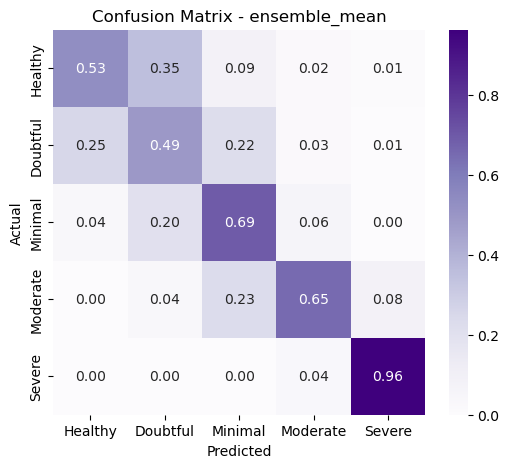

In [9]:
get_metrics(ensemble_mean, data=valid, name="ensemble_mean")
compute_confusion_matrix(
    ensemble_mean, class_names, data=valid, name="ensemble_mean"
)

### Valid: ensemble_acc

26/26 [==============================] - 58s 2s/step
Accuracy Score - ensemble_acc: 0.5944309927360775
Balanced Accuracy Score - ensemble_acc: 0.6655972937827788


              precision    recall  f1-score   support

           0       0.79      0.53      0.63       328
           1       0.32      0.49      0.38       153
           2       0.63      0.69      0.66       212
           3       0.73      0.65      0.69       106
           4       0.65      0.96      0.78        27

    accuracy                           0.59       826
   macro avg       0.62      0.67      0.63       826
weighted avg       0.65      0.59      0.61       826

Confusion matrix:
[[0.53 0.35 0.09 0.02 0.01]
 [0.25 0.49 0.22 0.03 0.01]
 [0.04 0.2  0.69 0.06 0.  ]
 [0.   0.04 0.23 0.65 0.08]
 [0.   0.   0.   0.04 0.96]]
Classes accuracies [0.53 0.49 0.69 0.65 0.96]
26/26 [==============================] - 57s 2s/step


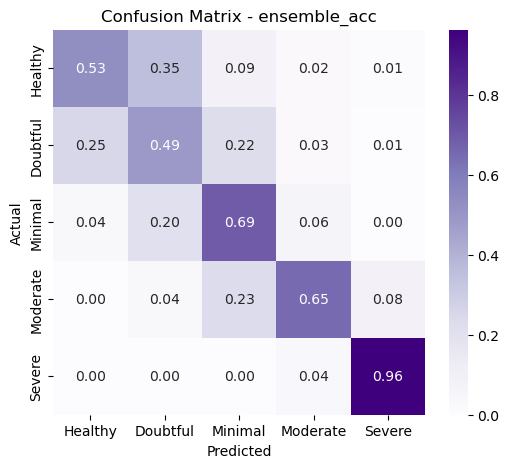

In [10]:
get_metrics(ensemble_acc, data=valid, name="ensemble_acc")
compute_confusion_matrix(
    ensemble_acc, class_names, data=valid, name="ensemble_acc"
)

### Valid: ensemble_f1

26/26 [==============================] - 55s 2s/step
Accuracy Score - ensemble_f1: 0.5944309927360775
Balanced Accuracy Score - ensemble_f1: 0.6655972937827788


              precision    recall  f1-score   support

           0       0.79      0.53      0.63       328
           1       0.32      0.49      0.38       153
           2       0.63      0.69      0.66       212
           3       0.73      0.65      0.69       106
           4       0.65      0.96      0.78        27

    accuracy                           0.59       826
   macro avg       0.62      0.67      0.63       826
weighted avg       0.65      0.59      0.61       826

Confusion matrix:
[[0.53 0.35 0.09 0.02 0.01]
 [0.25 0.49 0.22 0.03 0.01]
 [0.04 0.2  0.69 0.06 0.  ]
 [0.   0.04 0.23 0.65 0.08]
 [0.   0.   0.   0.04 0.96]]
Classes accuracies [0.53 0.49 0.69 0.65 0.96]
26/26 [==============================] - 56s 2s/step


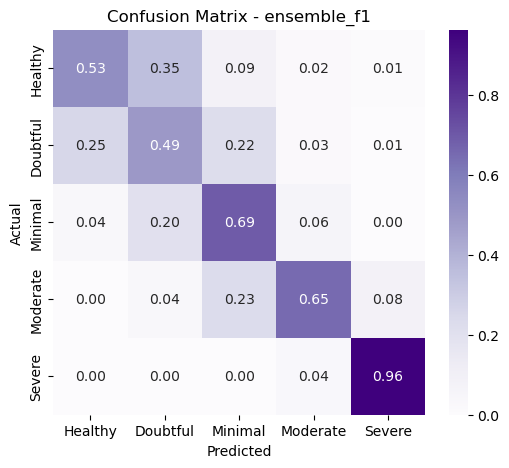

In [11]:
get_metrics(ensemble_f1, data=valid, name="ensemble_f1")
compute_confusion_matrix(
    ensemble_f1, class_names, data=valid, name="ensemble_f1"
)

### Results

| Model | Balanced Accuracy Score |
| ------| ----------------------- | 
| ensemble_mean | 68.63% | 
| ensemble_acc | 68.48% | 
| ensemble_f1 | 68.69% | 

### Test

Best result: `ensemble_f1` $68.68\%$

52/52 [==============================] - 118s 2s/step
Accuracy Score - ensemble_f1: 0.6165458937198067
Balanced Accuracy Score - ensemble_f1: 0.6710330503089348


              precision    recall  f1-score   support

           0       0.82      0.60      0.69       639
           1       0.31      0.46      0.37       296
           2       0.65      0.66      0.66       447
           3       0.73      0.71      0.72       223
           4       0.59      0.92      0.72        51

    accuracy                           0.62      1656
   macro avg       0.62      0.67      0.63      1656
weighted avg       0.66      0.62      0.63      1656

Confusion matrix:
[[0.6  0.32 0.07 0.01 0.  ]
 [0.23 0.46 0.27 0.03 0.01]
 [0.04 0.21 0.66 0.08 0.01]
 [0.   0.03 0.15 0.71 0.1 ]
 [0.   0.   0.   0.08 0.92]]
Classes accuracies [0.6  0.46 0.66 0.71 0.92]
52/52 [==============================] - 118s 2s/step


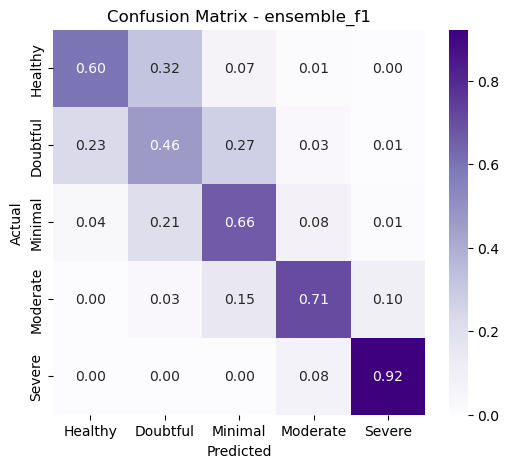

In [12]:
get_metrics(ensemble_f1, data=test, name="ensemble_f1")
compute_confusion_matrix(
    ensemble_f1, class_names, data=test, name="ensemble_f1"
)

#### Confusion matrix

In [13]:
y_true =test.labels
y_pred = np.argmax(ensemble_f1.predict(test), axis=1)

52/52 [==============================] - 112s 2s/step


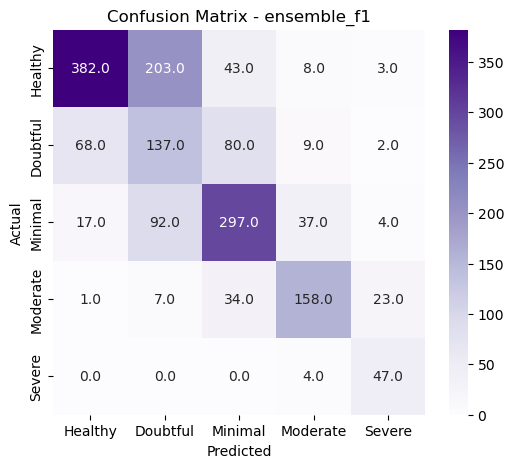

In [14]:
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

plt.subplots(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt=".1f",
    cmap="Purples",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.title(f"Confusion Matrix - ensemble_f1")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show(block=False)